#**<center>SPACESHIP TITANIC COMPETITATION</center>**

#**1. Problem Statement**

We needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!


<center><img src="https://storage.googleapis.com/kaggle-media/competitions/Spaceship%20Titanic/joel-filipe-QwoNAhbmLLo-unsplash.jpg" width=50%></center>


To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

#**2. Importing Libraries**

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from scipy import stats
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#**3. Loading Dataset**

In [3]:
data_train=pd.read_csv("/content/train.csv")
data_test=pd.read_csv("/content/test.csv")

In [4]:
print("data train shape:",data_train.shape)
data_train.head()

data train shape: (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
print("data test shape:",data_test.shape)
data_test.head()

data test shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


#**4. Data Description**

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


###**Observation**
 we have 1 bool,6 float64 and 7 objects dtypes.

In [7]:
data_train['Transported'].replace(to_replace=[False,True],value=['No','Yes'],inplace=True)

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 950.9+ KB


In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


###**Observation**
We have 6 float64 and 7 object dtypes.

#**5. Data Exploration**

##**5.1 Data pre processing**

###**Train data set**

In [10]:
data_train.duplicated().sum()

0

In [11]:
data_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [12]:
null = pd.DataFrame({"no of null value":data_train.isnull().sum(),
                     "percentage of nul value":(data_train.isnull().sum()/len(data_train))*100})
null

,no of null value,percentage of nul value
PassengerId,0,0.000000
HomePlanet,201,2.312205
CryoSleep,217,2.496261
Cabin,199,2.289198
Destination,182,2.093639
Age,179,2.059128
VIP,203,2.335212
RoomService,181,2.082135
FoodCourt,183,2.105142
ShoppingMall,208,2.392730


In [13]:
train_continuous_column=[]
train_categorical_column=[]
for i in data_train:
  if data_train[i].dtype=='object':
    train_categorical_column.append(i)
  elif data_train[i].dtype=='bool':
    train_categorical_column.append(i)
  else:
    train_continuous_column.append(i)

In [14]:
train_categorical_column

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name',
 'Transported']

We have categorical column and in these column there are missing value and there is no duplicated values in the entire train data, so to fill the missing value in the categorical column we use mean to fill missing value.

In [15]:
print(data_train["HomePlanet"].mode())
print(data_train['CryoSleep'].mode())
print(data_train['Cabin'].mode())
print(data_train['Destination'].mode())
print(data_train['VIP'].mode())

0    Earth
dtype: object
0    False
dtype: object
0    G/734/S
dtype: object
0    TRAPPIST-1e
dtype: object
0    False
dtype: object


In [16]:
data_train["HomePlanet"].fillna((data_train["HomePlanet"].mode()[0]),inplace=True )

In [17]:
data_train['CryoSleep'].fillna((data_train['CryoSleep'].mode()[0]),inplace=True )
data_train['Cabin'].fillna((data_train['Cabin'].mode()[0]),inplace=True )
data_train['Destination'].fillna((data_train['Destination'].mode()[0]),inplace=True )
data_train['VIP'].fillna((data_train['VIP'].mode()[0]),inplace=True )


In [18]:
train_continuous_column

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [19]:
data_train['Age'].fillna((data_train['Age'].mean()), inplace=True)
data_train['RoomService'].fillna((data_train['RoomService'].mean()), inplace=True)
data_train['FoodCourt'].fillna((data_train['FoodCourt'].mean()), inplace=True)
data_train['ShoppingMall'].fillna((data_train['ShoppingMall'].mean()), inplace=True)
data_train['Spa'].fillna((data_train['Spa'].mean()), inplace=True)
data_train['VRDeck'].fillna((data_train['VRDeck'].mean()), inplace=True)

In [20]:
data_train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64

In [21]:
# this is for only Numerical columns
data_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.339054,659.739364,1594.434978,597.417440,1124.675871,1133.259049
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,78.000000,118.000000,45.000000,89.000000,71.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


###**Observation**

* The average Age of passenger is 29 and the oldest passenger in the spaceship is 79 years.
* The average RoomService Amount the passenger has billed is 225 and the highest amount is 14327.
* The average FoodCourt Amount the passenger has billed is 458 and the highest amount is 29813.
* The average ShoppingMall Amount the passenger has billed is 174 and the highest amount is 23492.
* The average Spa Amount the passenger has billed is 311 and the highest amount is 22408.
* The average VRDeck Amount the passenger has billed is 305 and the highest amount is 24133
* And also here we need to find the passenger who are not billed for these things because we can find the value zero, in the dataset so lets consider value zero category is not paid.

###**Test data set**

In [22]:
data_test.duplicated().sum()

0

In [23]:
data_test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [24]:
null = pd.DataFrame({"no of null value":data_test.isnull().sum(),
                     "percentage of nul value":(data_test.isnull().sum()/len(data_test))*100})
null

,no of null value,percentage of nul value
PassengerId,0,0.000000
HomePlanet,87,2.034136
CryoSleep,93,2.174421
Cabin,100,2.338087
Destination,92,2.151040
Age,91,2.127660
VIP,93,2.174421
RoomService,82,1.917232
FoodCourt,106,2.478373
ShoppingMall,98,2.291326


In [25]:
test_continuous_column=[]
test_categorical_column=[]
for i in data_test:
  if data_test[i].dtype=='object':
    test_categorical_column.append(i)
  else:
    test_continuous_column.append(i)

In [26]:
data_test['HomePlanet'].fillna((data_test["HomePlanet"].mode()[0]), inplace=True)
data_test['CryoSleep'].fillna((data_test['CryoSleep'].mode()[0]), inplace=True)
data_test['Destination'].fillna((data_test['Destination'].mode()[0]), inplace=True)
data_test['VIP'].fillna((data_test['VIP'].mode()[0]), inplace=True)
data_test['Cabin'].fillna((data_test['Cabin'].mode()[0]), inplace=True)

In [27]:
data_test['Age'].fillna((data_test['Age'].mean()), inplace=True)
data_test['RoomService'].fillna((data_test['RoomService'].mean()), inplace=True)
data_test['FoodCourt'].fillna((data_test['FoodCourt'].mean()), inplace=True)
data_test['ShoppingMall'].fillna((data_test['ShoppingMall'].mean()), inplace=True)
data_test['Spa'].fillna((data_test['Spa'].mean()), inplace=True)
data_test['VRDeck'].fillna((data_test['VRDeck'].mean()), inplace=True)

In [28]:
data_test.isnull().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Cabin            0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Name            94
dtype: int64

###**5.2 Feature Engineering**

In data description they specifically mentioned that the,
- PassengerID is in ther format of gggg and pp, that is group name/ID and the group number, so we are creating new feature GroupId and the GroupNumber.
- In cabin we got 6560 different values, because cabin has 3 value in it like deck/num/side, where side can be either P for Port or S for Starboard, so we need to spilt deck and side as new feature
- There are passengers who are not billed for the Roomservice, foodcourt, spa, shoppingmall,vrdeck  

In [29]:
total_notpaid = data_train[(data_train['RoomService']==0) & (data_train['FoodCourt']==0)
&(data_train['ShoppingMall']==0) & (data_train['Spa']==0)&(data_train['VRDeck']==0)]


In [30]:
print(f'Ther are {total_notpaid.shape[0]} passengers who had not billed for the amount.')

Ther are 3247 passengers who had not billed for the amount.


These 3247 passenger has not billed for the amount but these passangers belongs to which age group we need to find out, so for the we create the age group categories like 
* childer = age 0 to 14
* youth = age 15 to 24
* adult =  age 25 to 64
* senior = age 65 and above

In [31]:
children_no = data_train[data_train['Age']<=14].shape[0]
youth_no =data_train[(data_train['Age']>=15) & (data_train['Age']<=24)].shape[0]
adult_no = data_train[(data_train['Age']>=25)& (data_train['Age']<=64)].shape[0]
senior_no = data_train[data_train['Age']>=65].shape[0]

In [32]:
print('Number of children passengers on titanic spaceship is :',children_no )
print('Number of young passengers on titanic spaceship is :',youth_no )
print('Number of adults passengers on titanic spaceship is :',adult_no )
print('Number of seniors passengers on titanic spaceship is :',senior_no )

Number of children passengers on titanic spaceship is : 1085
Number of young passengers on titanic spaceship is : 2568
Number of adults passengers on titanic spaceship is : 4933
Number of seniors passengers on titanic spaceship is : 107


So the majority of the passengers who are not billed is belongs to the age group of adults with the number 4933 and follows by youths with 2568

In [33]:
data_train.describe(include='object')

,PassengerId,HomePlanet,Cabin,Destination,Name,Transported
count,8693,8693,8693,8693,8493,8693
unique,8693,3,6560,3,8473,2
top,0001_01,Earth,G/734/S,TRAPPIST-1e,Gollux Reedall,Yes
freq,1,4803,207,6097,2,4378


Here we can observe that the 
- Majority of the people transported from Earth
- Majority of the people transported from Cabin G/734/S
- Majority of the people transported to TRAPPIST-1e
- Majority of the people transported successfully
- But the cabin has the 6560 unique categories or values in it so we cannot use directly to the model.

###**New feature of Train Data**

In [34]:
#Cabin has three values deck/num/side, so we'll create two columns for deck and side
data_train["Deck"] = data_train["Cabin"].apply(lambda x: str(x).split("/")[0])
data_train["side"] =data_train["Cabin"].apply(lambda x: x.split("/")[2])


In [35]:
#Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling 
#with and pp is their number within the group, so we'll create two new features GroupId and GroupIdNumber
data_train["GroupId"] = data_train["PassengerId"].apply(lambda x: x.split("_")[0])
data_train["GroupIdNumber"] =data_train["PassengerId"].apply(lambda x: x.split("_")[1])

In [36]:
# Creating new feature InGroup to indicate if a passenger is alone or in group
Group_train =data_train[data_train["GroupId"].duplicated()]["GroupId"]
data_train["InGroup"] = data_train["GroupId"].apply(lambda x: x in Group_train.values)

###**New feature of Test Data**

In [37]:
#Cabin has three values deck/num/side, so we'll create two columns for deck and side
data_test["Deck"] = data_test["Cabin"].apply(lambda x: str(x).split("/")[0])
data_test["side"] = data_test["Cabin"].apply(lambda x: x.split("/")[2])

In [38]:
#Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling 
#with and pp is their number within the group, so we'll create two new features GroupId and GroupIdNumber
data_test["GroupIdNumber"] = data_test["PassengerId"].apply(lambda x: x.split("_")[1])
data_test["GroupId"] = data_test["PassengerId"].apply(lambda x: x.split("_")[0])

In [39]:
# Creating new feature InGroup to indicate if a passenger is alone or in group
Group_test =data_test[data_test["GroupId"].duplicated()]["GroupId"]
data_test["InGroup"] = data_test["GroupId"].apply(lambda x: x in Group_test.values)

###**Droping unwanted columns**

In [40]:
print(data_train.shape)
data_train.head()

(8693, 19)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,side,GroupId,GroupIdNumber,InGroup
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,No,B,P,0001,01,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,Yes,F,S,0002,01,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,No,A,S,0003,01,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,No,A,S,0003,02,True
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,Yes,F,S,0004,01,False


In [41]:
#Drop 'PassengerId','Cabin','Name','GroupId','GroupIdNumber' from df_train
data_train.drop(['PassengerId','Cabin','Name','GroupId','GroupIdNumber'], axis=1, inplace=True)

#Save PassengerId and Name
Id_test_list = data_test["PassengerId"].tolist()

#Drop 'PassengerId','Cabin','Name','GroupId','GroupIdNumber' from df_test
data_test.drop(['PassengerId','Cabin','Name','GroupId','GroupIdNumber'], axis=1, inplace=True)

###**5.3 Exploratory Data Analysis** 

###**Univariate**

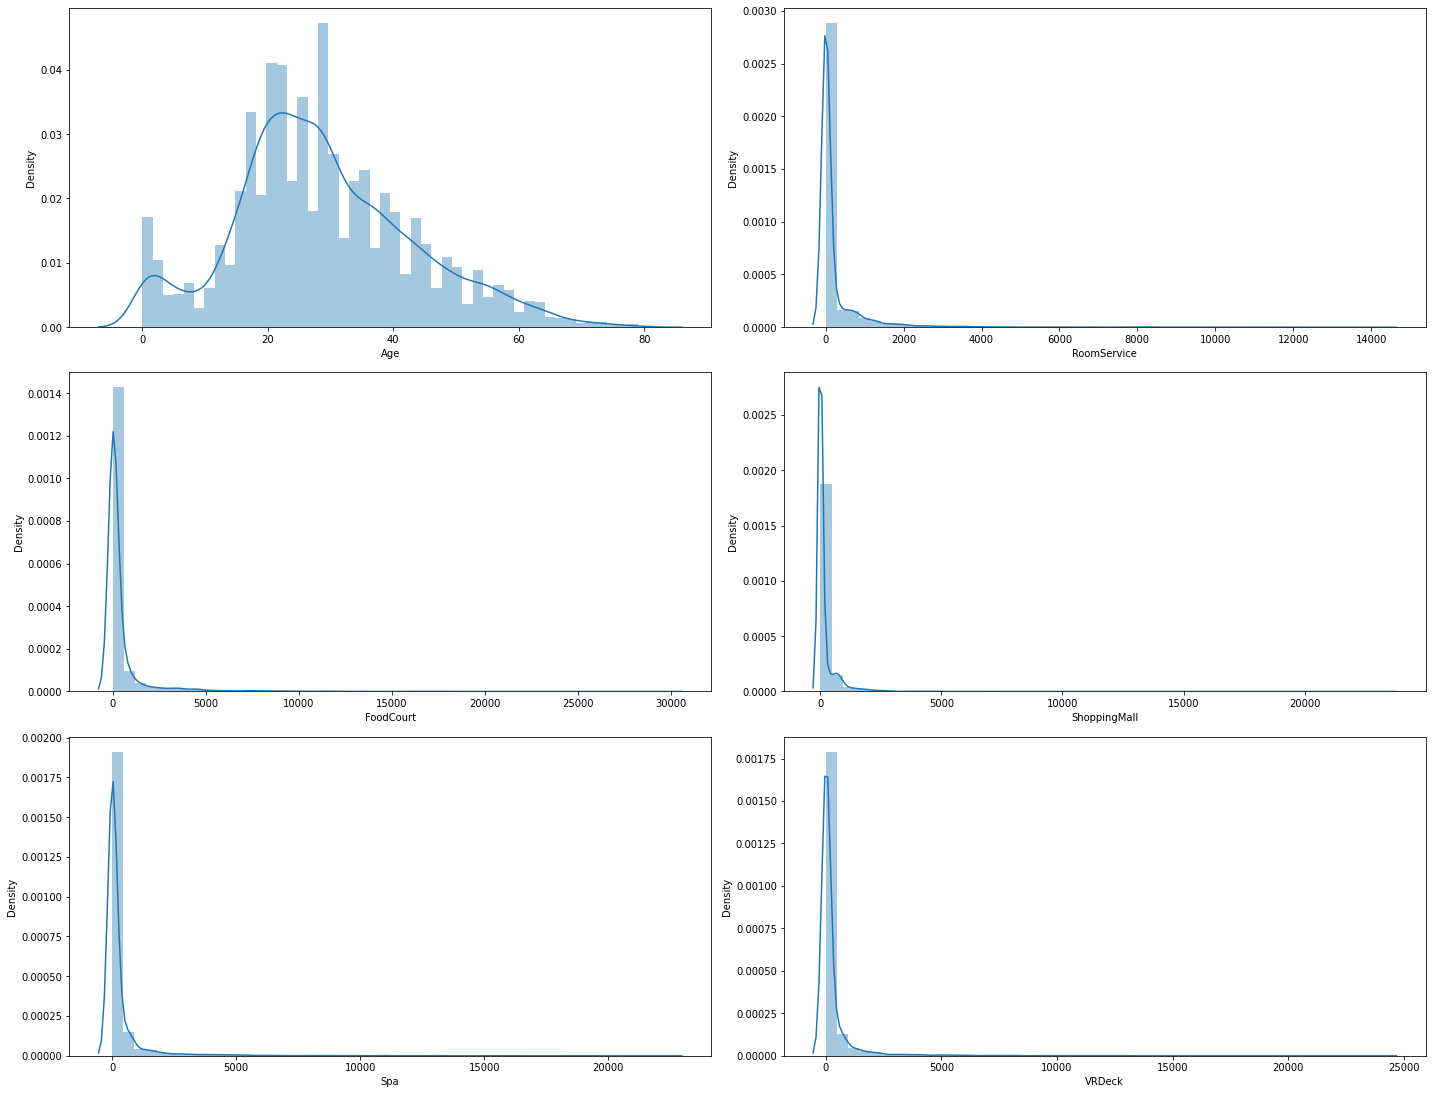

In [42]:
#Plot distribution of numerical columns
fig = plt.figure(figsize= (20,25))
for i, col in enumerate(train_continuous_column):
    
    ax=fig.add_subplot( 5, 2, i+1)
    
    sns.distplot(data_train[col])

fig.tight_layout()  
plt.show()

here we can see that the in continuous column:

* The distribution of age is normal distribution
* The distribution of the variables: RoomServie, FoodCourt, ShoppingMall, Spa, RDeck is skewed, we can confirme that using skew function.

for categorical data we have created the new columns so add those columns for the categorical features

In [43]:
new_categ_features=[col for col in data_train.select_dtypes(exclude=['number'])]
new_categ_features

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Transported',
 'Deck',
 'side',
 'InGroup']

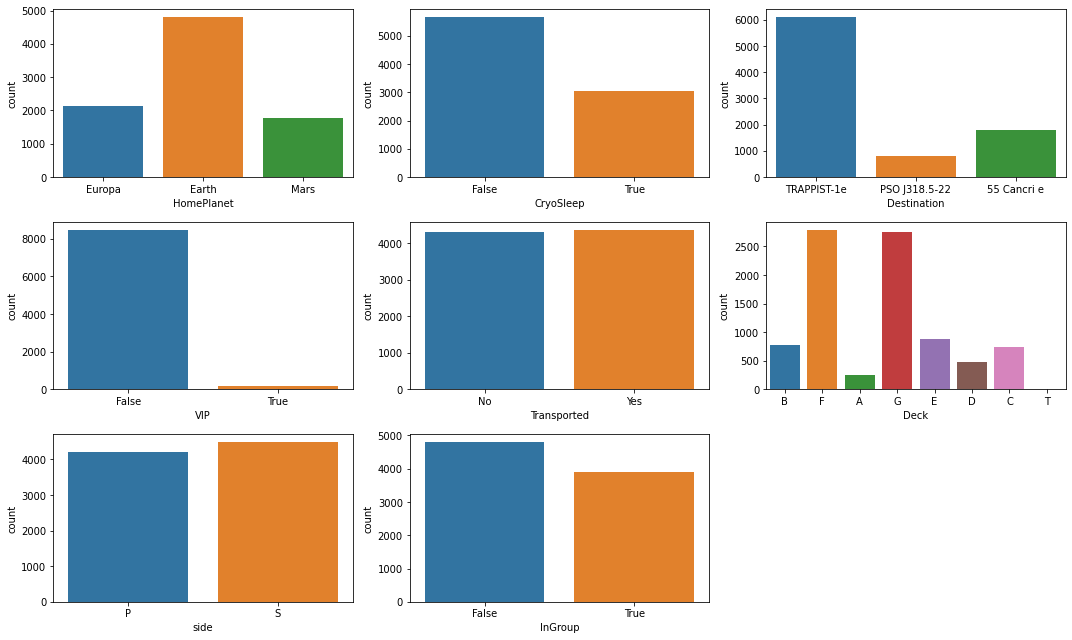

In [44]:
fig = plt.figure(figsize= (15,9))
for i, col in enumerate(new_categ_features):
  ax=fig.add_subplot(3, 3, i+1)
  sns.countplot(x=data_train[col], ax=ax)

fig.tight_layout()  
plt.show()

* Most passengers were traveling on both Deck F, G and on Starboard-side.
* More than half of passengers choose to travel alone.
*Few passengers were in CryoSleep.
*Passengers had an overall even chance of being transported

In [45]:
data_train[train_continuous_column].skew().sort_values(ascending=False)

ShoppingMall    12.781346
VRDeck           7.905655
Spa              7.717657
FoodCourt        7.178159
RoomService      6.399969
Age              0.423478
dtype: float64

here we can see that the expect age remaining are all highly skewed it is greater than 0-0.5, and we are going to remove these outliers before feature extraction

###**Bivariate**

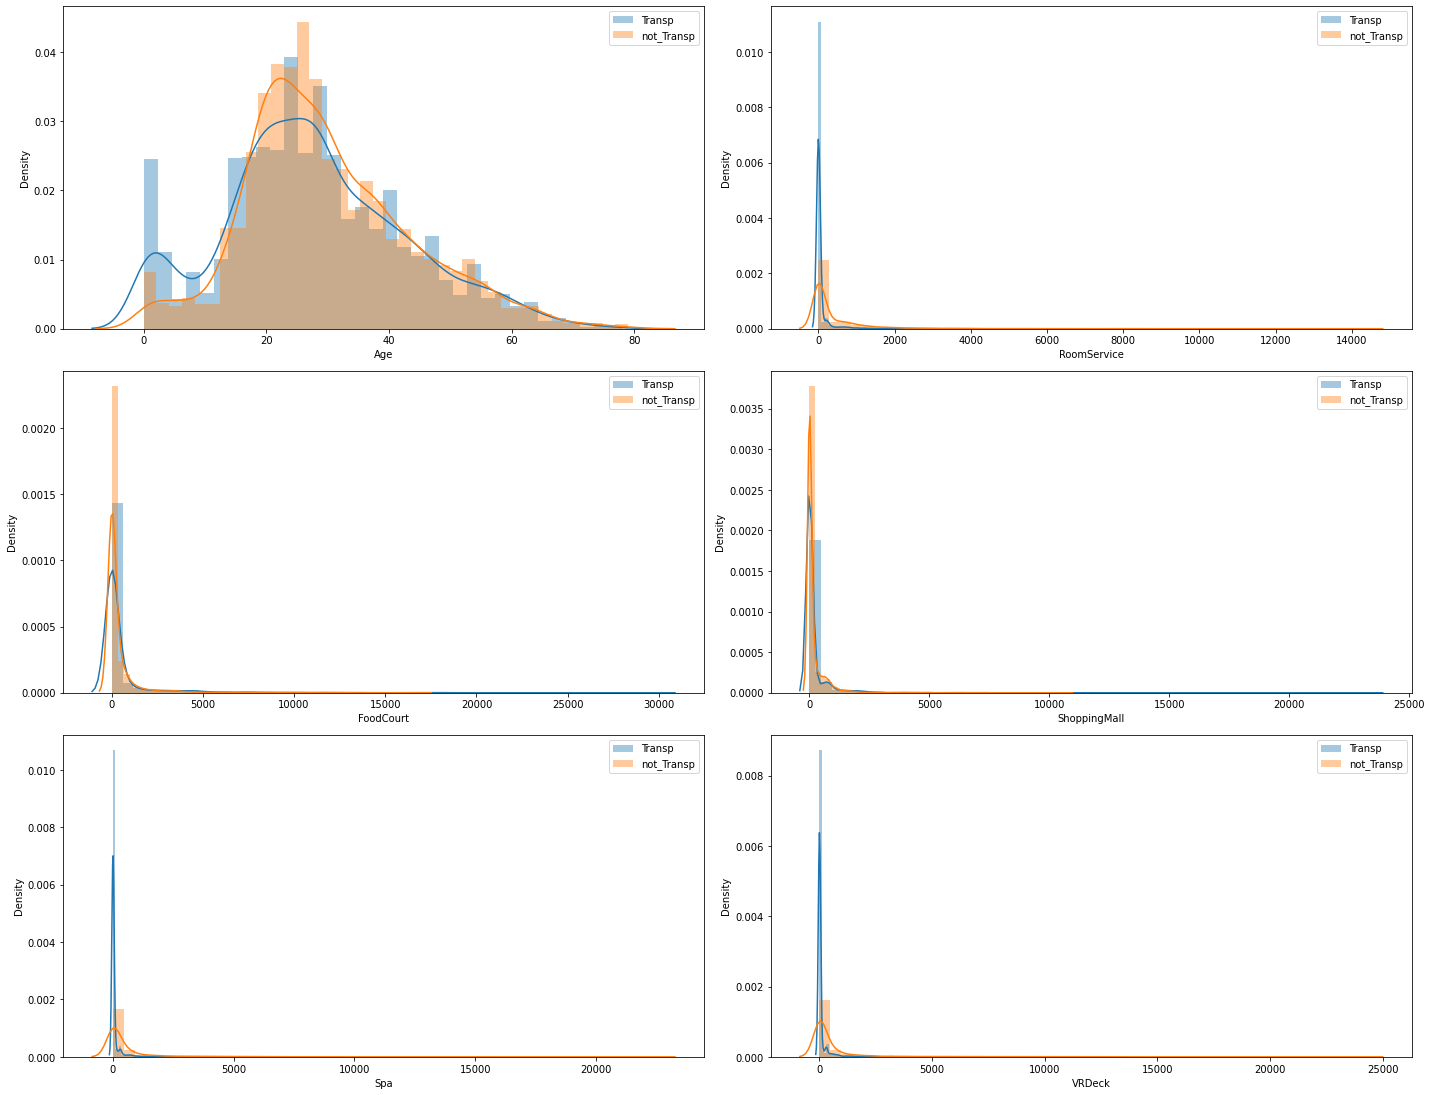

In [46]:
Transported_data=data_train[data_train['Transported']=='Yes']
NotTransported_data=data_train[data_train['Transported']=='No']
fig = plt.figure(figsize= (20,25))
for i, col in enumerate(train_continuous_column):
    
    ax=fig.add_subplot( 5, 2, i+1)
    
    sns.distplot(Transported_data[col],label='Transp')
    sns.distplot(NotTransported_data[col],label='not_Transp')
    plt.legend()
    
fig.tight_layout()  
plt.show()

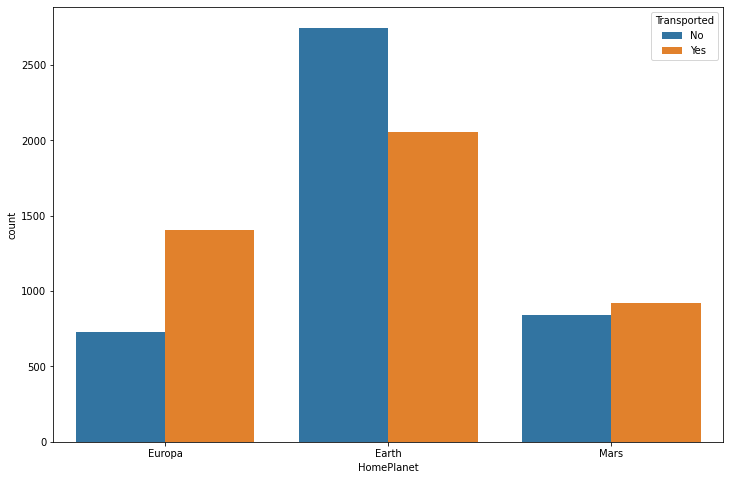

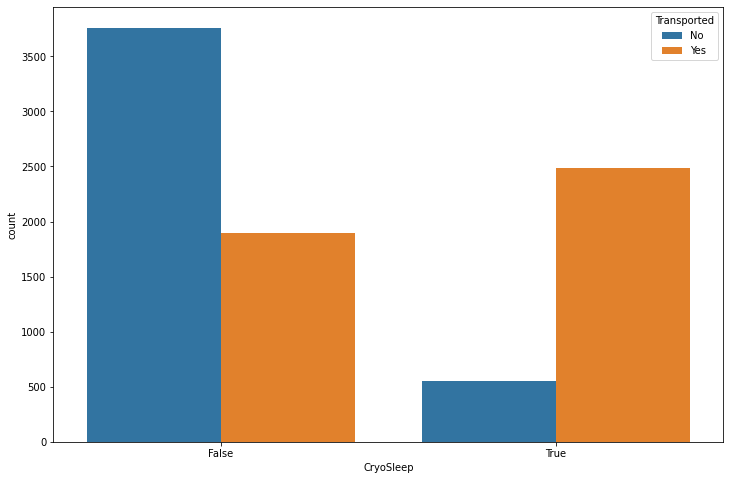

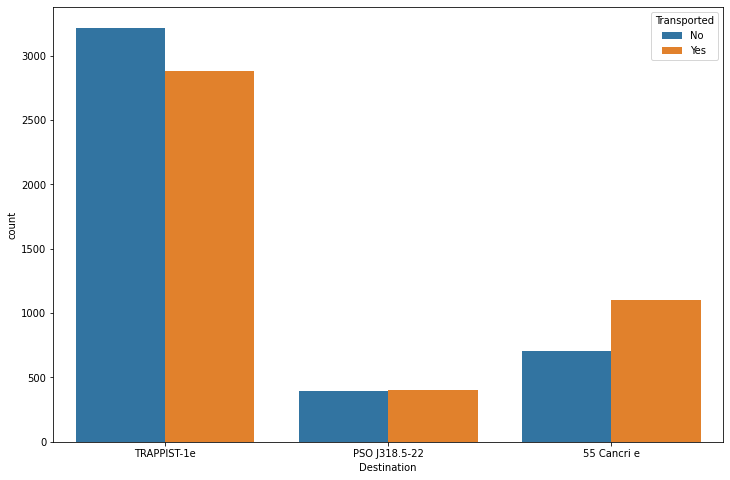

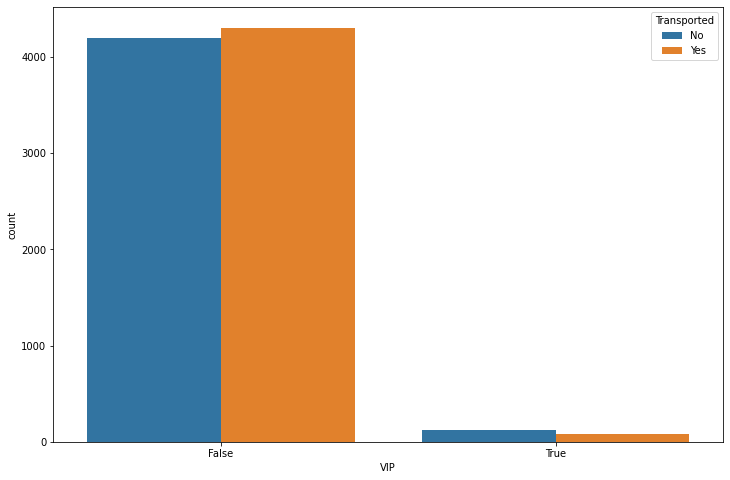

<Figure size 864x576 with 0 Axes>

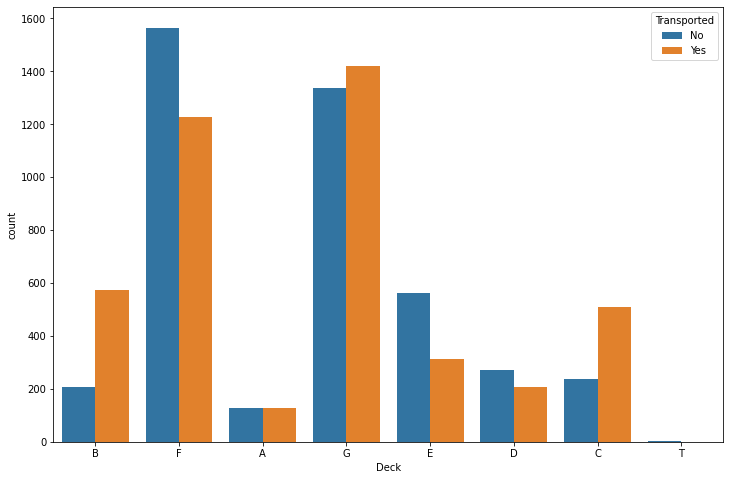

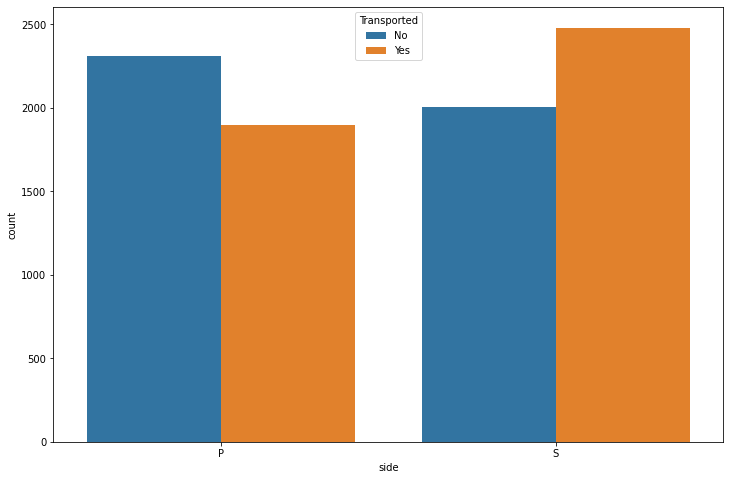

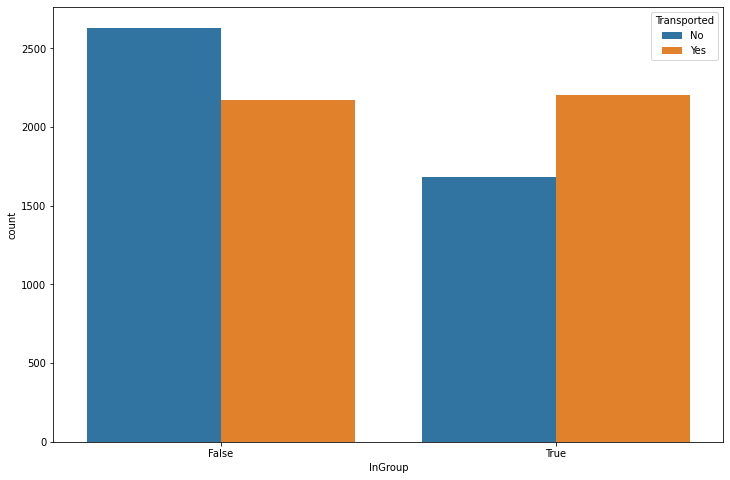

In [47]:
for col in new_categ_features:
    plt.figure(figsize=(12,8))
    if col!="Transported":
        sns.countplot(x=col,hue='Transported',data=data_train)

* Passengers from earth are less likely to be transported.
*Passengers in CryoSleep are more likely to be transported.
*Passengers who are traveling to Trappist-le are less likely to be transported.
*Being a VIP doesn't seem to significantly affect chances of being transported.
*passengers on decks F and port-side are more likely to be transported.
*Passengers who are traveling in group are less likely to be transported.

###**Multivariate**

In [48]:
data_train.corr()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,InGroup
CryoSleep,1.000000,-0.070736,-0.078281,-0.243986,-0.205682,-0.206366,-0.198392,-0.193107,0.091562
Age,-0.070736,1.000000,0.091574,0.067612,0.127937,0.032655,0.120992,0.099210,-0.133769
VIP,-0.078281,0.091574,1.000000,0.056595,0.126006,0.018483,0.060573,0.123092,0.034027
RoomService,-0.243986,0.067612,0.056595,1.000000,-0.015521,0.052962,0.009925,-0.019207,-0.019909
FoodCourt,-0.205682,0.127937,0.126006,-0.015521,1.000000,-0.013934,0.220587,0.224275,0.066816
ShoppingMall,-0.206366,0.032655,0.018483,0.052962,-0.013934,1.000000,0.013678,-0.007189,-0.028857
Spa,-0.198392,0.120992,0.060573,0.009925,0.220587,0.013678,1.000000,0.147957,0.043363
VRDeck,-0.193107,0.099210,0.123092,-0.019207,0.224275,-0.007189,0.147957,1.000000,0.043948
InGroup,0.091562,-0.133769,0.034027,-0.019909,0.066816,-0.028857,0.043363,0.043948,1.000000


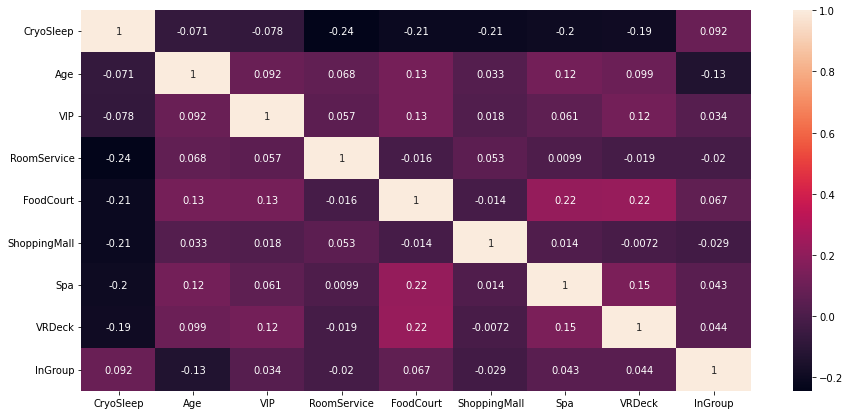

In [49]:
plt.figure(figsize=(15,7))
sns.heatmap(data_train.corr(), annot=True)
plt.show()

#**6. Data post processing**


### **Rwmoving Outliers**

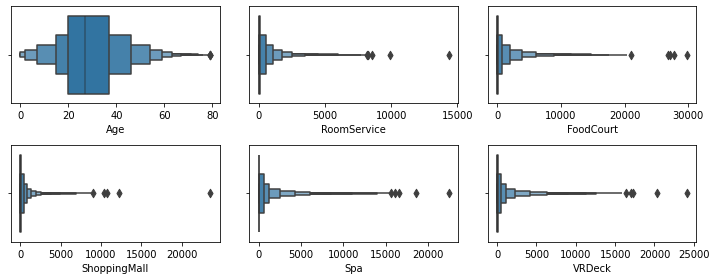

In [50]:
fig = plt.figure(figsize= (10,4))
for i, col in enumerate(train_continuous_column):
    
    ax=fig.add_subplot( 2, 3, i+1)
    
    sns.boxenplot(x=data_train[col],ax=ax)
fig.tight_layout()  
plt.show()

we can see it is a normal distribution or Gaussion Distribution, so we need to calculate the boundaries which differentiate the outliers.

In [51]:
#Remove some outliers from 
data_train=data_train[(data_train['FoodCourt']<20000)]
data_train=data_train[(data_train['RoomService']<7500)]
data_train=data_train[(data_train['Spa']<15000)]
data_train=data_train[(data_train['ShoppingMall']<7500)]
data_train=data_train[(data_train['VRDeck']<20000)]

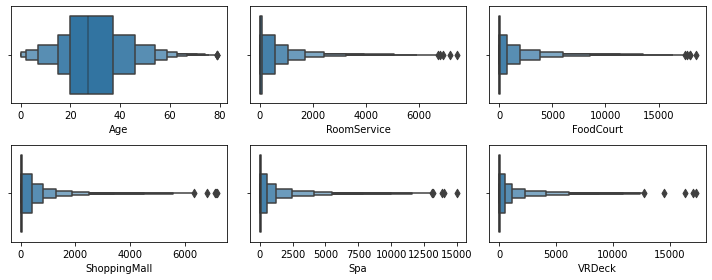

In [52]:
fig = plt.figure(figsize= (10,4))
for i, col in enumerate(train_continuous_column):
    
    ax=fig.add_subplot( 2, 3, i+1)
    
    sns.boxenplot(x=data_train[col],ax=ax)
fig.tight_layout()  
plt.show()

food court outliers

In [53]:
#IQR_food = data_train.FoodCourt.quantile(0.75)-data_train.FoodCourt.quantile(0.25)

In [54]:
#lower_bridge= data_train['FoodCourt'].quantile(0.25)-(IQR_food*3)
#upper_bridge = data_train['FoodCourt'].quantile(0.75)+(IQR_food*3)
#print(lower_bridge), print(upper_bridge)

In [55]:
#data_train.loc[data_train['FoodCourt']>=472,'FoodCourt']=472

ShoppingMall

In [56]:
#IQR_mall = data_train.ShoppingMall.quantile(0.75)-data_train.ShoppingMall.quantile(0.25)

In [57]:
#lower_bridge= data_train['ShoppingMall'].quantile(0.25)-(IQR_mall*3)
#upper_bridge = data_train['ShoppingMall'].quantile(0.75)+(IQR_mall*3)
#print(lower_bridge), print(upper_bridge)

In [58]:
#data_train.loc[data_train['ShoppingMall']>=180,'ShoppingMall']=180

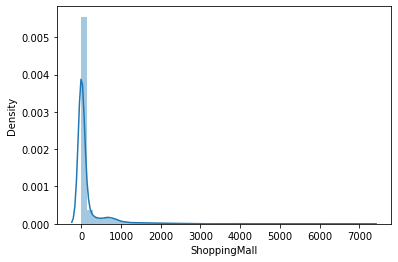

In [59]:
sns.distplot(data_train['ShoppingMall'])

Spa

In [60]:
#IQR_spa = data_train.Spa.quantile(0.75)-data_train.Spa.quantile(0.25)

In [61]:
#lower_bridge= data_train['Spa'].quantile(0.25)-(IQR_spa*3)
#upper_bridge = data_train['Spa'].quantile(0.75)+(IQR_spa*3)
#print(lower_bridge), print(upper_bridge)

In [62]:
#data_train.loc[data_train['Spa']>=356,'Spa']=356

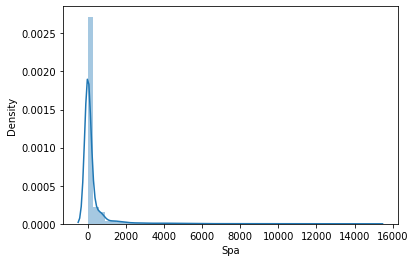

In [63]:
sns.distplot(data_train['Spa'])

VRDeck 

In [64]:
#IQR_deck = data_train.VRDeck.quantile(0.75)-data_train.VRDeck.quantile(0.25)

In [65]:
#lower_bridge= data_train['VRDeck'].quantile(0.25)-(IQR_deck*3)
#upper_bridge = data_train['VRDeck'].quantile(0.75)+(IQR_deck*3)
#print(lower_bridge), print(upper_bridge)

In [66]:
#data_train.loc[data_train['VRDeck']>=284,'VRDeck']=284

In [67]:
data_train[train_continuous_column].skew()

Age             0.421436
RoomService     4.862022
FoodCourt       5.946146
ShoppingMall    5.891302
Spa             6.666769
VRDeck          7.173685
dtype: float64

In [68]:
data_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,side,InGroup
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,No,B,P,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Yes,F,S,False
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,No,A,S,True
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,No,A,S,True
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Yes,F,S,False


### **6.1 Feature Selection**

###**feature selection from Numerical columns**

In [69]:
from scipy import stats
for col in train_continuous_column:
  df_anova = data_train[[col,'Transported']]
  grouped_anova = df_anova.groupby(['Transported'])
  f_value, p_value = stats.f_oneway(grouped_anova.get_group('Yes')[col],grouped_anova.get_group('No')[col])
  result = ""
  if p_value<0.05:
    result="{0} is IMPORTANT for Prediction".format(col)
  else:
    result="{0} is NOT an important predictor. (Discard {0} from model)".format(col)
  print(result)

Age is IMPORTANT for Prediction
RoomService is IMPORTANT for Prediction
FoodCourt is IMPORTANT for Prediction
ShoppingMall is NOT an important predictor. (Discard ShoppingMall from model)
Spa is IMPORTANT for Prediction
VRDeck is IMPORTANT for Prediction


###**Feature selection from Categorical columns**

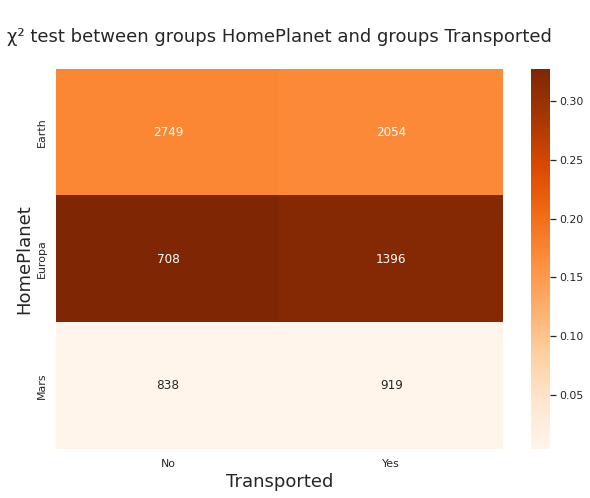

P-Value of the ChiSq Test bewteen HomePlanet and Transported is: 4.2745846940376305e-72

significance=0.050, p=0.000
Dependent (reject H0)


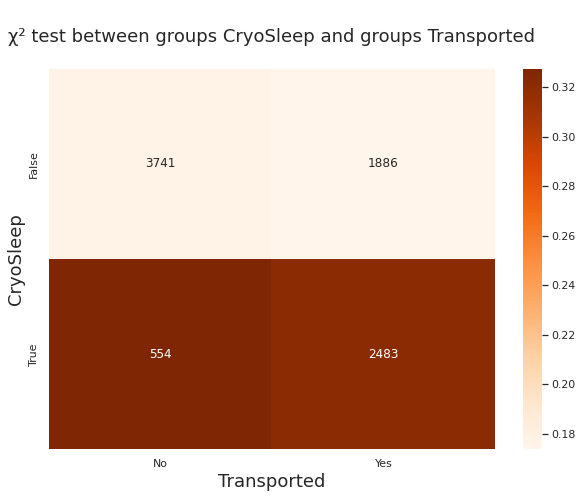

P-Value of the ChiSq Test bewteen CryoSleep and Transported is: 0.0

significance=0.050, p=0.000
Dependent (reject H0)


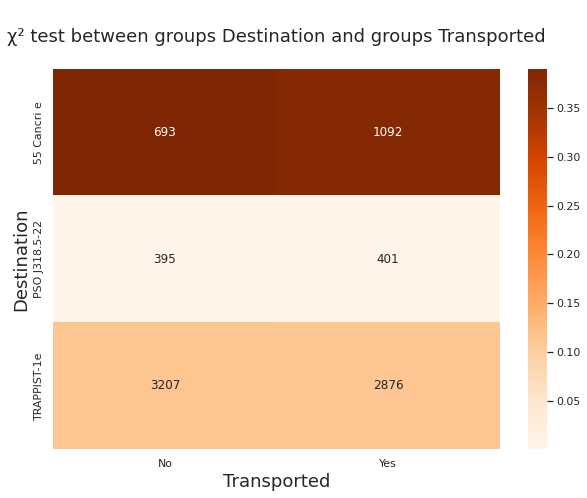

P-Value of the ChiSq Test bewteen Destination and Transported is: 7.042306179337985e-24

significance=0.050, p=0.000
Dependent (reject H0)


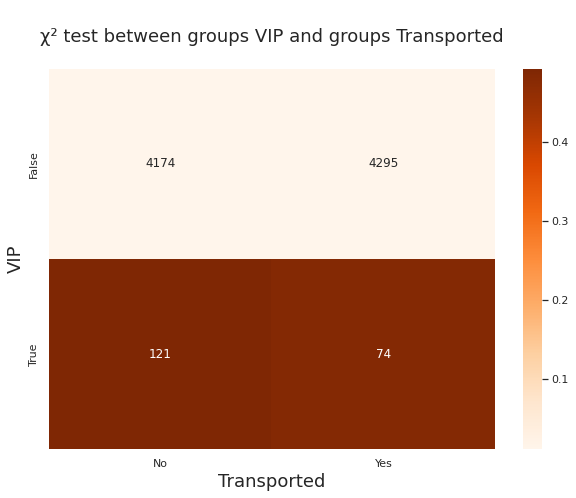

P-Value of the ChiSq Test bewteen VIP and Transported is: 0.0005552166849888812

significance=0.050, p=0.001
Dependent (reject H0)


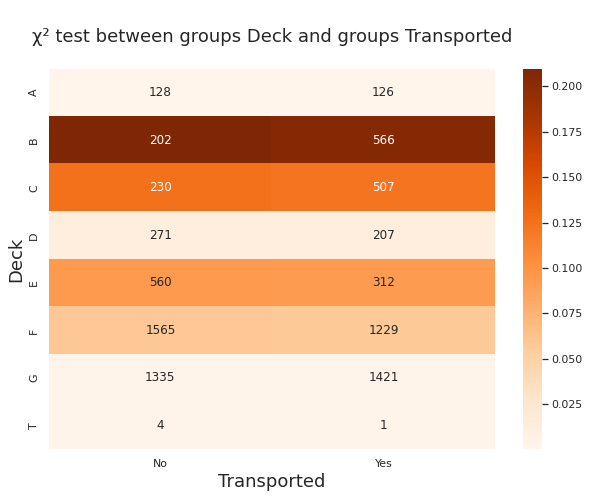

P-Value of the ChiSq Test bewteen Deck and Transported is: 2.344447181566512e-82

significance=0.050, p=0.000
Dependent (reject H0)


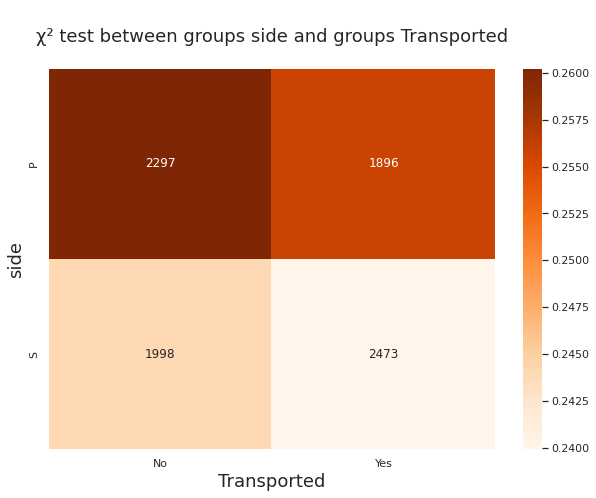

P-Value of the ChiSq Test bewteen side and Transported is: 7.296857282998763e-21

significance=0.050, p=0.000
Dependent (reject H0)


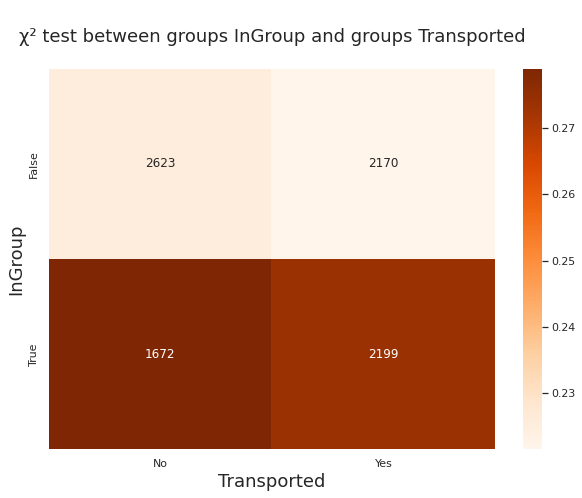

P-Value of the ChiSq Test bewteen InGroup and Transported is: 1.6974290787045092e-26

significance=0.050, p=0.000
Dependent (reject H0)


In [70]:
# Plot contingency table
data_train_categ=data_train[new_categ_features]
sns.set(rc={"figure.figsize": (10, 7)})
X = [col for col in new_categ_features if col!='Transported']
Y = ['Transported'] * len(X)

# Parameters for Chi-squared test (5% significance level)
prob = 0.95
alpha = 1.0 - prob

for i, j in zip(X, Y):
    # Contingency table
    cont = data_train_categ[[i, j]].pivot_table(
        index=i, columns=j, aggfunc=len, margins=True, margins_name="Total")
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(data_train_categ)
    indep = tx.dot(ty) / n
    c = cont.fillna(0)  # Replace NaN with 0 in the contingency table
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = measure / xi_n

    # Plot contingency table
    p = sns.heatmap(table.iloc[:-1, :-1],
                    annot=c.iloc[:-1, :-1], fmt=".0f", cmap="Oranges")
    p.set_xlabel(j, fontsize=18)
    p.set_ylabel(i, fontsize=18)
    p.set_title(f"\nχ² test between groups {i} and groups {j}\n", size=18)
    plt.show()

    # Performing Chi-sq test
    CrosstabResult = pd.crosstab(
        index=data_train_categ[i], columns=data_train_categ[j])
    ChiSqResult = chi2_contingency(CrosstabResult)
    # P-Value is the Probability of H0 being True
    print(f"P-Value of the ChiSq Test bewteen {i} and {j} is: {ChiSqResult[1]}\n")
    print('significance=%.3f, p=%.3f' % (alpha, ChiSqResult[1]))
    if ChiSqResult[1] <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')   

Loking at the result of Chi-square test we see that the variable "ShoppingMall" is not correlated with the target variable,so, we'll remove it from both training and test dataset.

In [71]:
#Remove "ShoppingMall" from both training and test dataset
data_train.drop(['ShoppingMall'], axis=1, inplace=True)
data_test.drop(['ShoppingMall'], axis=1, inplace=True)

In [72]:
data_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,Spa,VRDeck,Transported,Deck,side,InGroup
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,No,B,P,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,549.0,44.0,Yes,F,S,False
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,6715.0,49.0,No,A,S,True
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,3329.0,193.0,No,A,S,True
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,565.0,2.0,Yes,F,S,False


###**6.1 Feature label encoder**

a) Train data

In [73]:
encoder = LabelEncoder()
data_train['Transported']= encoder.fit_transform(data_train['Transported'])

In [74]:
data_train=pd.get_dummies(data_train,columns=['HomePlanet','CryoSleep','Destination','VIP','Deck','side','InGroup'])
data_train.head()

,Age,RoomService,FoodCourt,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,side_P,side_S,InGroup_False,InGroup_True
0,39.0,0.0,0.0,0.0,0.0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
1,24.0,109.0,9.0,549.0,44.0,1,1,0,0,1,...,0,0,0,1,0,0,0,1,1,0
2,58.0,43.0,3576.0,6715.0,49.0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
3,33.0,0.0,1283.0,3329.0,193.0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
4,16.0,303.0,70.0,565.0,2.0,1,1,0,0,1,...,0,0,0,1,0,0,0,1,1,0


b) Test data

In [75]:
data_test=pd.get_dummies(data_test,columns=['HomePlanet','CryoSleep','Destination','VIP','Deck','side','InGroup'])

###**6.2 Feature Extraction**

- here 1st we seperate data_train set into X (independent) and y (dependent) dataframes.
- spliting the train and validation
- checking the dependent is balanced or not, if not balance require measures are taken.

In [76]:
X = data_train.drop(['Transported'], axis=1)
y = data_train['Transported']

In [77]:
X_train, X_val, y_train, y_val = train_test_split(
...     X, y, test_size=0.30, random_state=42)

In [78]:
y.value_counts()

1    4369
0    4295
Name: Transported, dtype: int64

The target variable is balanced.

###**Test**

In [79]:
X_test = data_test

###**6.3 Feature scaling**

In [80]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_val)
scaler.transform(X_test)

array([[-0.12687684, -0.358607  , -0.29846056, ...,  0.96149281,
         0.88962508, -0.88962508],
       [-0.6846044 , -0.358607  , -0.29235789, ...,  0.96149281,
         0.88962508, -0.88962508],
       [ 0.15198694, -0.358607  , -0.29846056, ...,  0.96149281,
         0.88962508, -0.88962508],
       ...,
       [-0.01127761, -0.358607  , -0.29846056, ..., -1.04004938,
         0.88962508, -0.88962508],
       [-0.01127761, -0.358607  ,  1.51877942, ..., -1.04004938,
         0.88962508, -0.88962508],
       [ 0.98857827, -0.358607  , -0.29846056, ...,  0.96149281,
         0.88962508, -0.88962508]])

#**7. Modeling**

We'll train with,
* Logistic Regression
* Decision Tree
* KNN
* Support Vector Machine
* XGB Classifier
t* Gradient Boosting Classifier
* RandomFores
* Bagging Classifier

###**7.1 Logistic Regression**

In [81]:
log = LogisticRegression(class_weight='balanced', random_state=42)

In [82]:
  # Fit the model on train data
  log.fit(X_train, y_train)

  # Make predictions using test data
  y_pred_log = log.predict(X_test)

  # Make predictions using validation data
  y_val_pred_log = log.predict(X_val)

  # Make predictions using train data
  y_train_pred_log = log.predict(X_train)

   # F1 on train set
  f1_train_log = f1_score(y_train, y_train_pred_log)

  # F1 on validation set
  f1_val_log = f1_score(y_val, y_val_pred_log)


    # Display the accuracy of the model
  print('[F1-Score Train]:', f1_train_log)
  print('[F1-Score Validation]:', f1_val_log)

[F1-Score Train]: 0.7912408759124087
[F1-Score Validation]: 0.7860066989207294


###**Hyperparameter tuning**

In [83]:
# setup our GridsearchCV parameter
params = {'penalty':['l1','l2','elasticnet'],'C':[1,2,3,4,5,6,7,8,10,20,30,40,50],'max_iter':[100,200,300]}

In [84]:
# Initialize GridSearchCV
clf_log =GridSearchCV(log,param_grid=params,scoring='accuracy', cv=5)

In [85]:
# Fit the GridSearchCV training data
grid_fit_log=clf_log.fit(X_train,y_train)

In [86]:
best_clf_log = grid_fit_log.best_estimator_
grid_fit_log

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 30, 40, 50],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [87]:
best_clf_log.fit(X_train,y_train)

best_val_pred =best_clf_log.predict(X_val)

score_best = accuracy_score(y_val,best_val_pred)
score_best

best_param_log =clf_log.best_params_
best_param_log

{'C': 10, 'max_iter': 200, 'penalty': 'l2'}

In [88]:
# Rebuild the model with the best params
New_log = LogisticRegression(C= 2, max_iter= 200, penalty= 'l2')

# Fit the New model to X_train and y_train
New_log.fit(X_train,y_train)

# Make prediction on test data
y_test_New_log = New_log.predict(X_test)
y_test_New_log

# Make prediction on val
New_y_val_pred_log = log.predict(X_val)

# Make predictions using train data
New_y_train_pred_log = log.predict(X_train)

# F1 on train set
New_f1_train_log = f1_score(y_train, New_y_train_pred_log)

# F1 on validation set
New_f1_val_log = f1_score(y_val, New_y_val_pred_log)

# Display the accuracy of the model
print('[New F1-Score Train]:', New_f1_train_log)
print('[New F1-Score Validation]:', New_f1_val_log)

[New F1-Score Train]: 0.7912408759124087
[New F1-Score Validation]: 0.7860066989207294


In [89]:
print(classification_report(y_val,New_y_val_pred_log))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1299
           1       0.76      0.81      0.79      1301

    accuracy                           0.78      2600
   macro avg       0.78      0.78      0.78      2600
weighted avg       0.78      0.78      0.78      2600



###**7.2 Decision Tree Classifier**

In [90]:
dt = DecisionTreeClassifier()

In [91]:
# Fit the model on train data
dt.fit(X_train, y_train)

# Make predictions using test data
y_pred_dt = dt.predict(X_test)

# Make predictions using validation data
y_val_pred_dt = dt.predict(X_val)

# Make predictions using train data
y_train_pred_dt = dt.predict(X_train)

# F1 on train set
f1_train_dt = f1_score(y_train, y_train_pred_dt)

# F1 on validation set
f1_val_dt = f1_score(y_val, y_val_pred_dt)


# Display the accuracy of the model
print('[F1-Score Train]:', f1_train_dt)
print('[F1-Score Validation]:', f1_val_dt)

[F1-Score Train]: 0.9599607779048864
[F1-Score Validation]: 0.7346783403121431


In [92]:
params_dt ={'max_depth':[1,2,3,4,5,6],
            'min_samples_split':[10,20,30],
            'min_samples_leaf':[2,3,4]}

In [93]:
clf_dt = GridSearchCV(dt,params_dt,n_jobs=-1,cv=5)

In [94]:
grid_fit_dt = clf_dt.fit(X_train,y_train)

In [95]:
best_clf_dt = grid_fit_dt.best_estimator_
best_clf_dt

DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=10)

In [96]:
best_clf_dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=10)

In [97]:
best_val_predictions_dt = best_clf_dt.predict(X_val)

In [98]:
best_params_dt = clf_dt.best_params_
best_params_dt

{'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 10}

In [99]:
new_dt = DecisionTreeClassifier(max_depth= 4, min_samples_leaf= 2, min_samples_split= 10)

In [100]:
new_dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=10)

In [101]:
y_pred_dt_new = new_dt.predict(X_test)
y_pred_dt_new

array([1, 0, 1, ..., 1, 1, 1])

In [102]:
# Make prediction on val
New_y_val_pred_dt = new_dt.predict(X_val)

# Make predictions using train data
New_y_train_pred_dt = new_dt.predict(X_train)

# F1 on train set
New_f1_train_dt = f1_score(y_train, New_y_train_pred_dt)

# F1 on validation set
New_f1_val_dt = f1_score(y_val, New_y_val_pred_dt)

# Display the accuracy of the model
print('[New F1-Score Train]:', New_f1_train_dt)
print('[New F1-Score Validation]:', New_f1_val_dt)

[New F1-Score Train]: 0.7505712779047284
[New F1-Score Validation]: 0.7417110110519854


In [103]:
print(classification_report(y_val,New_y_val_pred_dt))

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1299
           1       0.79      0.70      0.74      1301

    accuracy                           0.76      2600
   macro avg       0.76      0.76      0.76      2600
weighted avg       0.76      0.76      0.76      2600



###**7.3 KNN**

In [104]:
knn = KNeighborsClassifier()
# Fit the model on train data
knn.fit(X_train, y_train)

# Make predictions using test data
y_pred_knn = knn.predict(X_test)

# Make predictions using validation data
y_val_pred_knn = knn.predict(X_val)

# Make predictions using train data
y_train_pred_knn = knn.predict(X_train)

# F1 on train set
f1_train_knn = f1_score(y_train, y_train_pred_knn)

# F1 on validation set
f1_val_knn = f1_score(y_val, y_val_pred_knn)


# Display the accuracy of the model
print('[F1-Score Train]:', f1_train_knn)
print('[F1-Score Validation]:', f1_val_knn)

[F1-Score Train]: 0.8278210116731517
[F1-Score Validation]: 0.7717968157695224


###**Hyperparameter tuning**

In [105]:
params_knn = {'n_neighbors':[3,50], 
              'weights':['uniform','distance'],
              'algorithm':['ball_tree','kd_tree','brute','auto'],
              'p':[1,2]
              }

In [106]:
clf_knn = GridSearchCV(knn,params_knn,cv=5)

In [107]:
grid_fit_knn = clf_knn.fit(X_train,y_train)

In [108]:
best_clf_knn = grid_fit_knn.best_estimator_
best_clf_knn

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=50)

In [109]:
best_clf_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=50)

In [110]:
best_val_predictions_knn = best_clf_knn.predict(X_val)

In [111]:
best_params_knn = clf_knn.best_params_
best_params_knn

{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 2, 'weights': 'uniform'}

###**Building new Knn with best parameter**

In [112]:
New_knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors= 50, p= 2, weights='uniform')

In [113]:
New_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=50)

In [114]:
y_pred_knn_new = New_knn.predict(X_test)
y_pred_knn_new

array([1, 0, 1, ..., 1, 1, 1])

In [115]:
# Make prediction on val
New_y_val_pred_knn = New_knn.predict(X_val)

# Make predictions using train data
New_y_train_pred_knn = New_knn.predict(X_train)

# F1 on train set
New_f1_train_knn = f1_score(y_train, New_y_train_pred_knn)

# F1 on validation set
New_f1_val_knn = f1_score(y_val, New_y_val_pred_knn)

# Display the accuracy of the model
print('[New F1-Score Train]:', New_f1_train_knn)
print('[New F1-Score Validation]:', New_f1_val_knn)

[New F1-Score Train]: 0.8046468969734026
[New F1-Score Validation]: 0.7879218472468916


In [116]:
print(classification_report(y_val,New_y_val_pred_knn))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1299
           1       0.73      0.85      0.79      1301

    accuracy                           0.77      2600
   macro avg       0.78      0.77      0.77      2600
weighted avg       0.78      0.77      0.77      2600



###**7.4 Support Vector Machine**

In [117]:
svm = SVC()
# Fit the model on train data
svm.fit(X_train, y_train)

# Make predictions using test data
y_pred_svm = svm.predict(X_test)

# Make predictions using validation data
y_val_pred_svm = svm.predict(X_val)

# Make predictions using train data
y_train_pred_svm = svm.predict(X_train)

# F1 on train set
f1_train_svm = f1_score(y_train, y_train_pred_svm)

# F1 on validation set
f1_val_svm = f1_score(y_val, y_val_pred_svm)


# Display the accuracy of the model
print('[F1-Score Train]:', f1_train_svm)
print('[F1-Score Validation]:', f1_val_svm)

[F1-Score Train]: 0.8107539801742265
[F1-Score Validation]: 0.7923344947735191


###**Hperparameter tuning**

In [118]:
params_svm = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf']}

In [119]:
grid_clf_svm = GridSearchCV(svm,params_svm,cv=5)

In [120]:
grid_fit_svm = grid_clf_svm.fit(X_train,y_train)

In [121]:
best_clf_svm = grid_fit_svm.best_estimator_
best_clf_svm

SVC(C=1)

In [122]:
best_params_svm = grid_clf_svm.best_params_
best_params_svm

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [123]:
new_svm = SVC(C= 1, gamma= 'scale', kernel= 'rbf')

In [124]:
new_svm.fit(X_train,y_train)

SVC(C=1)

In [125]:
new_y_pred_svm = new_svm.predict(X_test)

In [126]:
# Make prediction on val
New_y_val_pred_svm = new_svm.predict(X_val)

# Make predictions using train data
New_y_train_pred_svm = new_svm.predict(X_train)

# F1 on train set
New_f1_train_svm = f1_score(y_train, New_y_train_pred_svm)

# F1 on validation set
New_f1_val_svm = f1_score(y_val, New_y_val_pred_svm)

# Display the accuracy of the model
print('[New F1-Score Train]:', New_f1_train_svm)
print('[New F1-Score Validation]:', New_f1_val_svm)

[New F1-Score Train]: 0.8107539801742265
[New F1-Score Validation]: 0.7923344947735191


In [127]:
print(classification_report(y_val,New_y_val_pred_svm))

              precision    recall  f1-score   support

           0       0.84      0.67      0.74      1299
           1       0.72      0.87      0.79      1301

    accuracy                           0.77      2600
   macro avg       0.78      0.77      0.77      2600
weighted avg       0.78      0.77      0.77      2600



###**7.5 XGboost classifier**

In [128]:
from xgboost import XGBClassifier

In [129]:
 xgb=XGBClassifier()

In [130]:
#Fit the model on train data
xgb.fit(X_train, y_train)

# Make predictions using test data
y_pred_xgb = xgb.predict(X_test)

# Make predictions using validation data
y_val_pred_xgb = xgb.predict(X_val)

# Make predictions using train data
y_train_pred_xgb = xgb.predict(X_train)

# F1 on train set
f1_train_xgb = f1_score(y_train, y_train_pred_xgb)

# F1 on validation set
f1_val_xgb = f1_score(y_val, y_val_pred_xgb)


# Display the accuracy of the model
print('[F1-Score Train]:', f1_train_xgb)
print('[F1-Score Validation]:', f1_val_xgb)

[F1-Score Train]: 0.8203928905519177
[F1-Score Validation]: 0.7998557518932565


In [131]:
xg_param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

xgb = XGBClassifier(class_weight='balanced', random_state=42)

# Instantiate GridSearchCV
xg_cv = GridSearchCV (estimator = xgb, param_grid = xg_param_grid, scoring ='f1', cv = 5)

# fit the model
xg_cv.fit(X_train,y_train)

# returns the estimator with the best performance
print(xg_cv.best_estimator_)

print("[Hyperparameters]:", xg_cv.best_params_)
print("[Train Score]:", xg_cv.best_score_)
print("[Test Score]:", f1_score(y_val, xg_cv.predict(X_val)))

XGBClassifier(class_weight='balanced', max_depth=4, n_estimators=60,
              random_state=42)
[Hyperparameters]: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 60}
[Train Score]: 0.8117313569176557
[Test Score]: 0.8008689355539464


In [132]:
New_xgb = XGBClassifier(class_weight='balanced', random_state=42,learning_rate= 0.1, max_depth= 4, n_estimators= 60)

In [133]:
New_xgb.fit(X_train,y_train)

XGBClassifier(class_weight='balanced', max_depth=4, n_estimators=60,
              random_state=42)

In [134]:
new_y_pred_xgb = New_xgb.predict(X_test)

In [135]:
# Make prediction on val
New_y_val_pred_xgb = New_xgb.predict(X_val)

# Make predictions using train data
New_y_train_pred_xgb = New_xgb.predict(X_train)

# F1 on train set
New_f1_train_xgb = f1_score(y_train, New_y_train_pred_xgb)

# F1 on validation set
New_f1_val_xgb = f1_score(y_val, New_y_val_pred_xgb)

# Display the accuracy of the model
print('[New F1-Score Train]:', New_f1_train_xgb)
print('[New F1-Score Validation]:', New_f1_val_xgb)

[New F1-Score Train]: 0.8261209186064679
[New F1-Score Validation]: 0.8008689355539464


In [136]:
print(classification_report(y_val,New_y_val_pred_xgb))

              precision    recall  f1-score   support

           0       0.83      0.73      0.77      1299
           1       0.76      0.85      0.80      1301

    accuracy                           0.79      2600
   macro avg       0.79      0.79      0.79      2600
weighted avg       0.79      0.79      0.79      2600



###**7.6 Gradient Boosting Classifier**

In [137]:
gb=GradientBoostingClassifier()

In [138]:
#Fit the model on train data
gb.fit(X_train, y_train)

# Make predictions using test data
y_pred_gb = gb.predict(X_test)

# Make predictions using validation data
y_val_pred_gb = gb.predict(X_val)

# Make predictions using train data
y_train_pred_gb = gb.predict(X_train)

# F1 on train set
f1_train_gb = f1_score(y_train, y_train_pred_gb)

# F1 on validation set
f1_val_gb = f1_score(y_val, y_val_pred_gb)


# Display the accuracy of the model
print('[F1-Score Train]:', f1_train_gb)
print('[F1-Score Validation]:', f1_val_gb)

[F1-Score Train]: 0.8220512015077744
[F1-Score Validation]: 0.7997091966557616


In [139]:
parameters_gb = {
    "loss": ['deviance', 'exponential'],
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "min_samples_split": [2, 4, 6],
    "learning_rate":[0.01,0.1,1,10,100]
    }

# Instantiate GridSearchCV
gb_cv = GridSearchCV (gb, parameters_gb, cv = 5)

# fit the model
gb_cv.fit(X_train,y_train)

# returns the estimator with the best performance
print(gb_cv.best_estimator_)

print("[Hyperparameters]:", gb_cv.best_params_)
print("[Train Score]:", gb_cv.best_score_)
print("[Test Score]:", f1_score(y_val, gb_cv.predict(X_val)))

GradientBoostingClassifier(loss='exponential', max_depth=5, min_samples_split=6,
                           n_estimators=50)
[Hyperparameters]: {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 50}
[Train Score]: 0.7993100051967275
[Test Score]: 0.794289897510981


In [140]:
new_gb = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators=250)

In [141]:
#Fit the model on train data
new_gb.fit(X_train, y_train)

# Make predictions using test data
new_y_pred_gb = new_gb.predict(X_test)

# Make predictions using validation data
new_y_val_pred_gb = new_gb.predict(X_val)

# Make predictions using train data
new_y_train_pred_gb = new_gb.predict(X_train)

# F1 on train set
New_f1_train_gb = f1_score(y_train, new_y_train_pred_gb)

# F1 on validation set
New_f1_val_gb = f1_score(y_val, new_y_val_pred_gb)


# Display the accuracy of the model
print('[F1-Score Train]:', New_f1_train_gb)
print('[F1-Score Validation]:', New_f1_val_gb)

[F1-Score Train]: 0.8393224631945543
[F1-Score Validation]: 0.8048600883652431


In [142]:
print(classification_report(y_val,new_y_val_pred_gb))

              precision    recall  f1-score   support

           0       0.82      0.75      0.79      1299
           1       0.77      0.84      0.80      1301

    accuracy                           0.80      2600
   macro avg       0.80      0.80      0.80      2600
weighted avg       0.80      0.80      0.80      2600



###**7.7 RandomFores**

In [143]:
rm = RandomForestClassifier()

In [144]:
#Fit the model on train data
rm.fit(X_train, y_train)

# Make predictions using test data
y_pred_rm = rm.predict(X_test)

# Make predictions using validation data
y_val_pred_rm = rm.predict(X_val)

# Make predictions using train data
y_train_pred_rm = rm.predict(X_train)

# F1 on train set
f1_train_rm = f1_score(y_train, y_train_pred_rm)

# F1 on validation set
f1_val_rm = f1_score(y_val, y_val_pred_rm)


# Display the accuracy of the model
print('[F1-Score Train]:', f1_train_rm)
print('[F1-Score Validation]:', f1_val_rm)

[F1-Score Train]: 0.9606299212598425
[F1-Score Validation]: 0.7799288818648755


In [145]:
param_grid_rm = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, 120],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#initializing GridSearchCv
rm_cv = GridSearchCV(estimator = rm, param_grid = param_grid_rm, cv = 3, n_jobs = -1, verbose = 2, scoring=make_scorer(f1_score))

# fit the model
rm_cv.fit(X_train,y_train)

# returns the estimator with the best performance
print(rm_cv.best_estimator_)

print("[Hyperparameters]:", rm_cv.best_params_)
print("[Train Score]:", rm_cv.best_score_)
print("[Test Score]:", f1_score(y_val, rm_cv.predict(X_val)))


Fitting 3 folds for each of 360 candidates, totalling 1080 fits
RandomForestClassifier(max_depth=90, max_features=3, min_samples_leaf=4,
                       min_samples_split=10)
[Hyperparameters]: {'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
[Train Score]: 0.7905711770922107
[Test Score]: 0.7889697433933358


In [146]:
new_rm =RandomForestClassifier(bootstrap= True, max_depth= 90, max_features= 3, 
                               min_samples_leaf= 3, min_samples_split= 8, n_estimators= 300)

In [147]:
#Fit the model on train data
new_rm.fit(X_train, y_train)

# Make predictions using test data
new_y_pred_rm = new_rm.predict(X_test)

# Make predictions using validation data
new_y_val_pred_rm = new_rm.predict(X_val)

# Make predictions using train data
new_y_train_pred_rm = new_rm.predict(X_train)

# F1 on train set
New_f1_train_rm = f1_score(y_train, new_y_train_pred_rm)

# F1 on validation set
New_f1_val_rm = f1_score(y_val, new_y_val_pred_rm)


# Display the accuracy of the model
print('[F1-Score Train]:', New_f1_train_rm)
print('[F1-Score Validation]:', New_f1_val_rm)

[F1-Score Train]: 0.8583061889250815
[F1-Score Validation]: 0.7904652056901194


In [148]:
print(classification_report(y_val,new_y_val_pred_rm))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1299
           1       0.79      0.79      0.79      1301

    accuracy                           0.79      2600
   macro avg       0.79      0.79      0.79      2600
weighted avg       0.79      0.79      0.79      2600



###**7.8 Cat Boost Classifier**

In [149]:
cb=CatBoostClassifier()

In [150]:
#Fit the model on train data
cb.fit(X_train, y_train)

# Make predictions using test data
y_pred_cb = cb.predict(X_test)

# Make predictions using validation data
y_val_pred_cb = cb.predict(X_val)

# Make predictions using train data
y_train_pred_cb = cb.predict(X_train)

# F1 on train set
f1_train_cb = f1_score(y_train, y_train_pred_cb)

# F1 on validation set
f1_val_cb = f1_score(y_val, y_val_pred_cb)


# Display the accuracy of the model
print('[F1-Score Train]:', f1_train_cb)
print('[F1-Score Validation]:', f1_val_cb)

Learning rate set to 0.022242
0:	learn: 0.6827207	total: 51.7ms	remaining: 51.6s
1:	learn: 0.6718188	total: 55.4ms	remaining: 27.7s
2:	learn: 0.6606837	total: 59ms	remaining: 19.6s
3:	learn: 0.6500192	total: 62.6ms	remaining: 15.6s
4:	learn: 0.6406448	total: 66.2ms	remaining: 13.2s
5:	learn: 0.6296034	total: 69.8ms	remaining: 11.6s
6:	learn: 0.6197613	total: 73.3ms	remaining: 10.4s
7:	learn: 0.6124324	total: 76.9ms	remaining: 9.54s
8:	learn: 0.6052683	total: 82.6ms	remaining: 9.1s
9:	learn: 0.5974061	total: 92ms	remaining: 9.11s
10:	learn: 0.5921351	total: 102ms	remaining: 9.16s
11:	learn: 0.5866922	total: 106ms	remaining: 8.69s
12:	learn: 0.5812322	total: 110ms	remaining: 8.38s
13:	learn: 0.5759855	total: 115ms	remaining: 8.1s
14:	learn: 0.5686517	total: 119ms	remaining: 7.81s
15:	learn: 0.5647545	total: 125ms	remaining: 7.67s
16:	learn: 0.5595098	total: 129ms	remaining: 7.44s
17:	learn: 0.5532506	total: 136ms	remaining: 7.4s
18:	learn: 0.5492583	total: 140ms	remaining: 7.22s
19:	lear

In [151]:

grid_cb = {'max_depth': [3,4,5],'n_estimators':[100, 200, 300]}

# Instantiate GridSearchCV
gscv_cb = GridSearchCV (estimator = cb, param_grid = grid_cb, scoring ='f1', cv = 5)

# fit the model
gscv_cb.fit(X_train,y_train)

# returns the estimator with the best performance
print(gscv_cb.best_estimator_)

print("[Hyperparameters]:", gscv_cb.best_params_)
print("[Train Score]:", gscv_cb.best_score_)
print("[Test Score]:", f1_score(y_val, gscv_cb.predict(X_val)))

Streaming output truncated to the last 5000 lines.
26:	learn: 0.4463254	total: 63.5ms	remaining: 407ms
27:	learn: 0.4454373	total: 67.6ms	remaining: 415ms
28:	learn: 0.4440088	total: 69.9ms	remaining: 412ms
29:	learn: 0.4428818	total: 72.2ms	remaining: 409ms
30:	learn: 0.4399688	total: 74.5ms	remaining: 406ms
31:	learn: 0.4387619	total: 76.9ms	remaining: 404ms
32:	learn: 0.4363538	total: 79.3ms	remaining: 401ms
33:	learn: 0.4348013	total: 81.6ms	remaining: 398ms
34:	learn: 0.4338662	total: 83.9ms	remaining: 396ms
35:	learn: 0.4319156	total: 86.4ms	remaining: 394ms
36:	learn: 0.4309883	total: 88.9ms	remaining: 392ms
37:	learn: 0.4293932	total: 91.3ms	remaining: 389ms
38:	learn: 0.4282626	total: 93.5ms	remaining: 386ms
39:	learn: 0.4273888	total: 95.9ms	remaining: 383ms
40:	learn: 0.4258825	total: 98ms	remaining: 380ms
41:	learn: 0.4243178	total: 100ms	remaining: 378ms
42:	learn: 0.4224939	total: 103ms	remaining: 378ms
43:	learn: 0.4211996	total: 107ms	remaining: 379ms
44:	learn: 0.42034

In [152]:
New_cb=CatBoostClassifier(max_depth= 4, n_estimators= 100)

In [153]:
#Fit the model on train data
New_cb.fit(X_train, y_train)

# Make prediction on val
New_y_val_pred_cb = New_cb.predict(X_val)

# Make predictions using train data
New_y_train_pred_cb = New_cb.predict(X_train)

# F1 on train set
New_f1_train_cb = f1_score(y_train, New_y_train_pred_cb)

# F1 on validation set
New_f1_val_cb = f1_score(y_val, New_y_val_pred_cb)

# Display the accuracy of the model
print('[New F1-Score Train]:', New_f1_train_cb)
print('[New F1-Score Validation]:', New_f1_val_cb)

Learning rate set to 0.183727
0:	learn: 0.6281316	total: 2.73ms	remaining: 270ms
1:	learn: 0.5862953	total: 5.48ms	remaining: 268ms
2:	learn: 0.5568136	total: 7.94ms	remaining: 257ms
3:	learn: 0.5267679	total: 10.7ms	remaining: 257ms
4:	learn: 0.5084257	total: 13.5ms	remaining: 256ms
5:	learn: 0.4953219	total: 16ms	remaining: 250ms
6:	learn: 0.4808871	total: 18.7ms	remaining: 248ms
7:	learn: 0.4705111	total: 21.4ms	remaining: 246ms
8:	learn: 0.4640439	total: 24.2ms	remaining: 245ms
9:	learn: 0.4562252	total: 27ms	remaining: 243ms
10:	learn: 0.4522470	total: 29.7ms	remaining: 240ms
11:	learn: 0.4492485	total: 32.1ms	remaining: 236ms
12:	learn: 0.4437623	total: 34.8ms	remaining: 233ms
13:	learn: 0.4413548	total: 37.3ms	remaining: 229ms
14:	learn: 0.4376240	total: 40.1ms	remaining: 227ms
15:	learn: 0.4358230	total: 42.6ms	remaining: 224ms
16:	learn: 0.4344065	total: 45.1ms	remaining: 220ms
17:	learn: 0.4325235	total: 47.5ms	remaining: 217ms
18:	learn: 0.4297472	total: 50.1ms	remaining: 21

In [154]:
print(classification_report(y_val,New_y_val_pred_cb))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1299
           1       0.78      0.83      0.80      1301

    accuracy                           0.79      2600
   macro avg       0.80      0.79      0.79      2600
weighted avg       0.80      0.79      0.79      2600



### **7.9 Now trying with ensembling model with bagging to improve the model prediction**

lets create the base model with the multiple model which is already used to predict.

In [155]:
# Create list of base models
base_models = [log,dt,knn, svm]

In [156]:
# Create list of hyperparameters to tune
param_grid_bag = {'base_estimator': base_models,
              'n_estimators': [10, 20, 30],
              'max_samples': [0.5, 0.7, 1.0],
              'max_features': [0.5, 0.7, 1.0],
              'bootstrap': [True, False]}

# Create bagging classifier
bag = BaggingClassifier()

# Create grid search object
grid_search = GridSearchCV(bag, param_grid_bag, cv=5)

# Fit grid search to the data
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters: ", grid_search.best_params_)

# Make predictions on val data
y_pred_val_bag = grid_search.predict(X_val)

# Make predictions on test data
y_pred_bag = grid_search.predict(X_test)

Best Parameters:  {'base_estimator': SVC(), 'bootstrap': False, 'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 30}


In [157]:
print(classification_report(y_val,y_pred_val_bag))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      1299
           1       0.73      0.86      0.79      1301

    accuracy                           0.77      2600
   macro avg       0.78      0.77      0.77      2600
weighted avg       0.78      0.77      0.77      2600



###**Conculsion:**


In [158]:
best_model = {
    'Model Name':['Logestic Regression','Decision Tree','Knn','Support Vector Classifier','XGboost','Gradient Boost','Random Forest'],
    'New F1-Score Train':[New_f1_train_log, New_f1_train_dt, New_f1_train_knn, New_f1_train_svm,New_f1_train_xgb,New_f1_train_gb,New_f1_train_rm],
    'New F1-Score Validation':[New_f1_val_log,New_f1_val_dt, New_f1_val_knn, New_f1_val_svm, New_f1_val_xgb, New_f1_val_gb,New_f1_val_rm]
}

In [159]:
selection=pd.DataFrame(best_model)
selection

,Model Name,New F1-Score Train,New F1-Score Validation
0,Logestic Regression,0.791241,0.786007
1,Decision Tree,0.750571,0.741711
2,Knn,0.804647,0.787922
3,Support Vector Classifier,0.810754,0.792334
4,XGboost,0.826121,0.800869
5,Gradient Boost,0.839322,0.804860
6,Random Forest,0.858306,0.790465


In [160]:
from sklearn.metrics import classification_report
print(classification_report(y_val,new_y_val_pred_gb))#check for every model here highest accuracy is Gradient Boosting

              precision    recall  f1-score   support

           0       0.82      0.75      0.79      1299
           1       0.77      0.84      0.80      1301

    accuracy                           0.80      2600
   macro avg       0.80      0.80      0.80      2600
weighted avg       0.80      0.80      0.80      2600



In [161]:
new_y_pred_gb

array([1, 0, 1, ..., 1, 1, 1])

###**Submission**

In [162]:
pred = pd.DataFrame(new_y_pred_gb)

In [163]:
pred = pred.replace(to_replace=1,value="True")

In [164]:
pred = pred.replace(to_replace=0,value="False")


In [165]:
pred

,0
0,True
1,False
2,True
3,True
4,True
...,...
4272,True
4273,False
4274,True
4275,True


In [166]:
subm= pd.read_csv("/content/test.csv")

In [167]:
datasets=pd.concat([subm['PassengerId'],pred], axis = 1)

In [168]:
datasets.columns =['PassengerId','Transported']

In [169]:
datasets.to_csv('sample_submission.csv', index= False)